In [9]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt

In [10]:
# Generate example data (Replace this with your actual dataset)
num_samples = 1000  # Number of samples
num_classes = 10    # Number of classes
X_train = np.random.rand(num_samples, 224, 224, 3).astype(np.float32)  
y_train = np.random.randint(0, num_classes, num_samples)  

print("X_train shape:", X_train.shape) 
print("y_train shape:", y_train.shape) 

X_train shape: (1000, 224, 224, 3)
y_train shape: (1000,)


In [11]:
# Load pre-trained MobileNetV2 model + higher-level layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Display the model architecture
base_model.summary()


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [12]:
# Freeze the lower convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Check which layers are frozen
frozen_layers = [layer.name for layer in base_model.layers if not layer.trainable]
print("Frozen layers:", frozen_layers)

Frozen layers: ['input_layer_2', 'Conv1', 'bn_Conv1', 'Conv1_relu', 'expanded_conv_depthwise', 'expanded_conv_depthwise_BN', 'expanded_conv_depthwise_relu', 'expanded_conv_project', 'expanded_conv_project_BN', 'block_1_expand', 'block_1_expand_BN', 'block_1_expand_relu', 'block_1_pad', 'block_1_depthwise', 'block_1_depthwise_BN', 'block_1_depthwise_relu', 'block_1_project', 'block_1_project_BN', 'block_2_expand', 'block_2_expand_BN', 'block_2_expand_relu', 'block_2_depthwise', 'block_2_depthwise_BN', 'block_2_depthwise_relu', 'block_2_project', 'block_2_project_BN', 'block_2_add', 'block_3_expand', 'block_3_expand_BN', 'block_3_expand_relu', 'block_3_pad', 'block_3_depthwise', 'block_3_depthwise_BN', 'block_3_depthwise_relu', 'block_3_project', 'block_3_project_BN', 'block_4_expand', 'block_4_expand_BN', 'block_4_expand_relu', 'block_4_depthwise', 'block_4_depthwise_BN', 'block_4_depthwise_relu', 'block_4_project', 'block_4_project_BN', 'block_4_add', 'block_5_expand', 'block_5_expand_

In [13]:
# Create a new model with the base and custom classifier
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Adjust the number of classes as needed

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the complete model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.0872 - loss: 2.7247 - val_accuracy: 0.0800 - val_loss: 2.4360
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.0994 - loss: 2.4083 - val_accuracy: 0.1000 - val_loss: 2.3600
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.1117 - loss: 2.3361 - val_accuracy: 0.1150 - val_loss: 2.4616
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.1228 - loss: 2.3643 - val_accuracy: 0.0750 - val_loss: 2.3619
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.1700 - loss: 2.3020 - val_accuracy: 0.1000 - val_loss: 2.4389
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.1351 - loss: 2.2979 - val_accuracy: 0.1050 - val_loss: 2.4054
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.1400 - loss: 2.2995 - val_accuracy: 0.0850 - val_loss: 2.3482
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.1571 - loss: 2.2775 - val_accuracy: 0.0950 - val_loss:

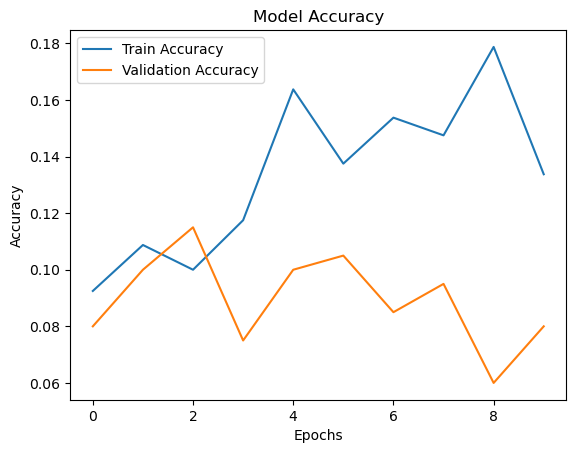

In [6]:
# Train the classifier layers
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Plot training history (optional)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
# Unfreeze some of the last convolutional layers for fine-tuning
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers; adjust as needed
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Continue training with fine-tuning
fine_tune_history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.0964 - loss: 2.5321 - val_accuracy: 0.0700 - val_loss: 2.4020
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.1333 - loss: 2.4030 - val_accuracy: 0.0700 - val_loss: 2.3959
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.1466 - loss: 2.2753 - val_accuracy: 0.0950 - val_loss: 2.3923
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.2151 - loss: 2.2417 - val_accuracy: 0.1050 - val_loss: 2.3914
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.2502 - loss: 2.1910 - val_accuracy: 0.1050 - val_loss: 2.3889


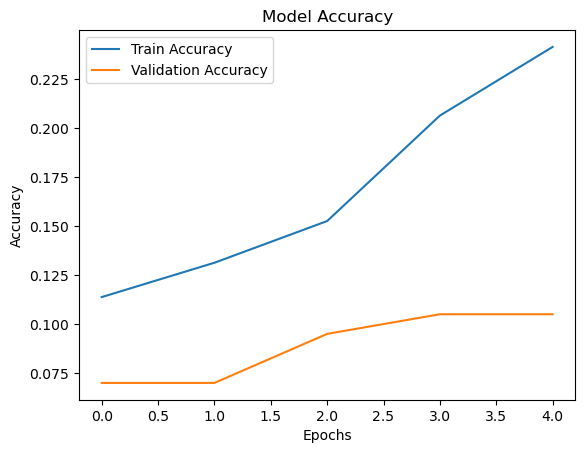

In [8]:
# Plot training history (optional)
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()